# SPICE Example 2 - LORRI observarions of Charon during the 2014 flyby #
Here we'll derive a few things about the upcoming EDL image that HiRISE will take. We start by importing the SpiceyPy module and other useful things.

> Annex et al., (2020). SpiceyPy: a Pythonic Wrapper for the SPICE Toolkit. Journal of Open Source Software, 5(46), 2050, https://doi.org/10.21105/joss.02050

Things we'll learn about SPICE (and SpicyPy) here:
* Meta kernels
* ID-name conversions
* Retrieve FOV corner vectors
* Intersect FOV with object

Start with the usual module imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as spice
from mpl_toolkits.mplot3d import Axes3D

kernel_home = "/Users/shane/Desktop/PTYS_551_code/PTYS_551_kernels/"

Meta Kernels save a lot of time. They're text files that list many kernels and can be furnsh'ed with a single command. They're very useful when frequent updates to kernels come out as you can edit the meta-kernel without changing any code.

In [10]:
spice.furnsh(kernel_home+"nh/dude_thats_so_meta.tm")

The contents of ```dude_thats_so_meta.tm``` are shown below. Note the need for absolute paths - you need to edit the meta kernel I provided 
```
\begintext
   
Text comments can go here if needed.
Note we define a path symbol as NAIF have a strict limit on the length of a line in a meta kernel
Many comma-separated path symbols can be defined if kernels are stored in separate places

The first two kernels below ar standard leap-second and planetary constants kernels.
The next three describe the New Horizons spacecraft i.e. the clock, the frames system, and the LORRI instrument.
The final three describe the position and orientation of the spacecraft and Pluto-system bodies.

\begindata

   PATH_VALUES  = ( '/Users/shane/Desktop/PTYS_551_code/PTYS_551_kernels/nh/' )
   PATH_SYMBOLS = ( 'NH')

KERNELS_TO_LOAD = ( '$NH/naif0012.tls',
                    '$NH/pck00010.tpc',
                    '$NH/new_horizons_1454.tsc',
                    '$NH/nh_lorri_v201.ti',
                    '$NH/nh_v220.tf',
                    '$NH/nh_recon_pluto_od122_v01.bsp',
                    '$NH/merged_nhpc_2014_v001.bc',
                    '$NH/merged_nhpc_2015_v001.bc' )

\begintext

You can go back and forth between text and data as many times as you like in these files.
```


In [11]:
spcid  = spice.bodn2c('NEW HORIZONS')      # Retrieve the ID code for the spacecraft
instid = spice.bodn2c('NH_LORRI')          # Retrieve the ID code for the instrument

[shape, frame, bsight, nbounds, bounds] = spice.getfov(instid, 20)  # Find the corner points of the LORRI FOV

print(shape)
for i in range(0,nbounds):
    print(bounds[i,:])

RECTANGLE
[ 0.00254134 -0.00254134 -0.99999354]
[-0.00254134 -0.00254134 -0.99999354]
[-0.00254134  0.00254134 -0.99999354]
[ 0.00254134  0.00254134 -0.99999354]


In [12]:
utc1 = '2015-07-01T00:00:00'  # Flyby was in July 2015 sometime. I forget exactly when, but no matter...
utc2 = '2015-07-31T23:59:59'
et1 = spice.utc2et(utc1) 
et2 = spice.utc2et(utc2)

cell = spice.cell_double(2)
spice.wninsd(et1,et2,cell)
ww = spice.cell_double(2000)

spice.gfdist('CHARON', 'LT+S', 'NEW_HORIZONS', 'ABSMIN', 0, 0, 10, 20, cell, ww)   # Find time of closest approach to Charon
[zz, et0] = spice.wnfetd(ww,0)                                                     # There should only be one time range and it should have zero duration

print('Closest Approach of NH to Charon is at ',spice.et2utc(et0,'ISOC',1))
# Narrow the Ephemeris time window to about an hour, centered on closest approach
et1 = et0 - 1800
et2 = et0 + 1800

cell = spice.cell_double(2)
spice.wninsd(et1,et2,cell)
ww = spice.cell_double(2000)

spice.gftfov('NH_LORRI','CHARON', 'ELLIPSOID', 'IAU_CHARON', 'LT+S', 'NEW_HORIZONS', 5.0, cell, ww)

print("Within an hour of closest approach, Charon was with LORRI's FOV within these time ranges")
for i in range(0,spice.wncard(ww)):
    [et1, et2] = spice.wnfetd(ww,i)
    print(spice.et2utc(et1,'ISOC',1), "  to  ",spice.et2utc(et2,'ISOC',1))

Closest Approach of NH to Charon is at  2015-07-14T12:02:22.1
Within an hour of closest approach, Charon was with LORRI's FOV within these time ranges
2015-07-14T11:48:06.3   to   2015-07-14T11:48:50.1


Great! So we have a window where LORRI was pointed at CHARON while close by. We don't know if LORRI actually took a picture then, but let's assume it did. What is the image footprint on the surface? Let's figure that out at the beginning of the window.

In [13]:
[num, radii] = spice.bodvrd('CHARON', 'RADII', 3)  # Retrieve Charon Radii to help conversion to lat/lon

for i in range(0,nbounds):
    dvec = bounds[i,:]
    with spice.no_found_check():
        [spoint, trgepc, srfvec,f] = spice.sincpt('ELLIPSOID','CHARON',et1, 'IAU_CHARON', 'LT+S','NEW HORIZONS',frame,dvec)
        [lon, lat, alt] = spice.recpgr('CHARON', spoint, radii[0], (radii[0]-radii[2])/radii[0])
    print(f,lon*180/np.pi,lat*180/np.pi)

False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0


oh no! What's going on? 
Probably something like this...
<img src="charon_miss.jpg" width="200">

The white square (LORRI FOV) might include Charon while still having all its corners not intersect the body. Let's try the middle of the time window.

In [14]:
[num, radii] = spice.bodvrd('CHARON', 'RADII', 3)  # Retrieve Charon Radii to help conversion to lat/lon
lorri_lon = np.zeros(nbounds+1)
lorri_lat = np.zeros(nbounds+1)

utc0 = '2015-07-14T11:48:28.851'
et0 = spice.utc2et(utc0)


for i in range(0,nbounds):
    dvec = bounds[i,:]
    with spice.no_found_check():
        [spoint, trgepc, srfvec,f] = spice.sincpt('ELLIPSOID','CHARON',et0, 'IAU_CHARON', 'LT+S','NEW HORIZONS',frame,dvec)
        [lon, lat, alt] = spice.recpgr('CHARON', spoint, radii[0], (radii[0]-radii[2])/radii[0])
        lorri_lon[i] = 360.0-lon*180/np.pi
        lorri_lat[i] = lat*180/np.pi
    print(f,360.0-lon*180/np.pi,lat*180/np.pi)
    
lorri_lon[nbounds] = lorri_lon[0]
lorri_lat[nbounds] = lorri_lat[0]

lorri_lon[3] = lorri_lon[3]-360.0

True 12.611883471049168 -3.998399760599668
True 21.41266161580546 -16.23628424664985
True 8.30058080052828 -24.855502292682008
True 359.9015157511577 -12.146727550317953


(-5.0, 25.0)

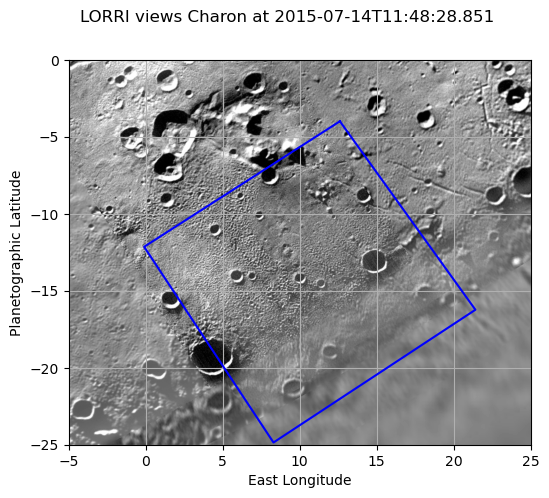

In [16]:
bg = plt.imread('Charon_NewHorizons_Global_Mosaic_300m_Jul2017_1024.jpg')
fig, ax = plt.subplots(1,1,figsize=(10,5))
fig.suptitle('LORRI views Charon at '+utc0)
ax.imshow(bg, extent=[-180,180, -90,90],cmap='gray')
ax.plot(lorri_lon,lorri_lat,color='#0000ff')
ax.set_xlabel('East Longitude')
ax.set_ylabel('Planetographic Latitude')
ax.set_ylim(-90,90)
ax.set_xlim(-180,180)
ax.grid(True)

ax.set_ylim(-25,0)
ax.set_xlim(-5,25)


What about illumination conditions?

In [17]:
[spoint, trgepc, srfvec] = spice.sincpt('ELLIPSOID','CHARON',et0, 'IAU_CHARON', 'LT+S','NEW HORIZONS',frame,bsight)
[phase, solar, emissn] = spice.illum('CHARON', et0, 'LT+S', 'NEW HORIZONS', spoint)

print('Phase Angle',phase*180/np.pi)
print('Incidence Angle',solar*180/np.pi)
print('Emission Angle',emissn*180/np.pi)

Phase Angle 83.27573791651888
Incidence Angle 85.3181512351214
Emission Angle 2.7787165167431875
